In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import ylabel

/tmp/ipykernel_853495/3091791864.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load('output.pt')


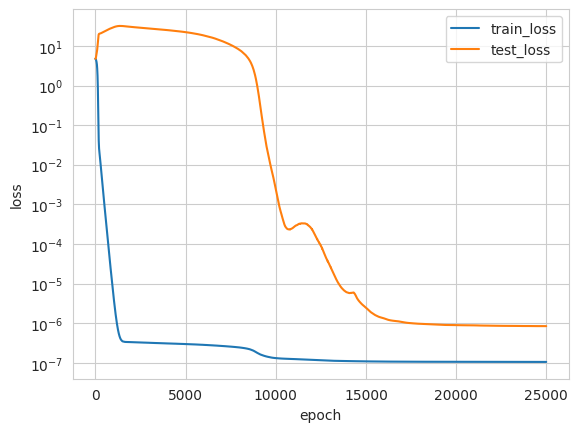

In [3]:
results = torch.load('output.pt')
plt.plot(results['train_losses'])
plt.plot(results['test_losses'])

plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss'])

In [4]:
results.keys()

dict_keys(['model', 'config', 'checkpoints', 'checkpoint_epochs', 'test_losses', 'train_losses', 'train_data', 'test_data'])

/tmp/ipykernel_853495/1060897627.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load('output_plus_and_minus.pt')


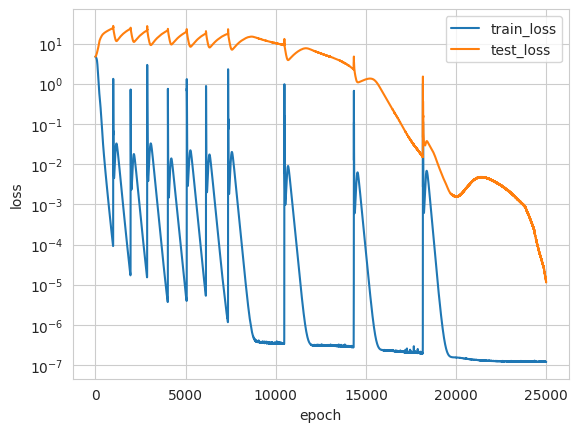

In [5]:
results = torch.load('output_plus_and_minus.pt')
plt.plot(results['train_losses'])
plt.plot(results['test_losses'])

plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss',])


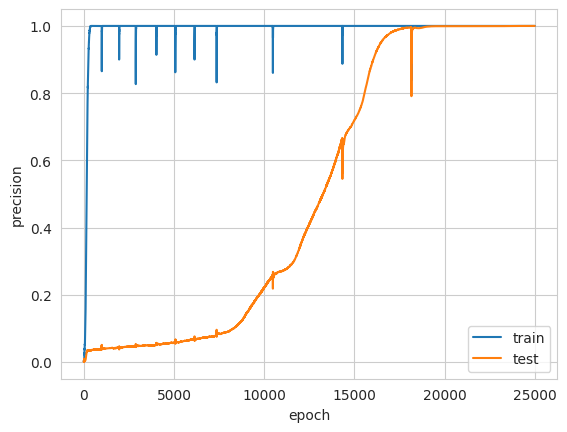

In [6]:
results.keys()
plt.plot(results['train_precision_scores'])
plt.plot(results['test_precision_scores'])
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'])


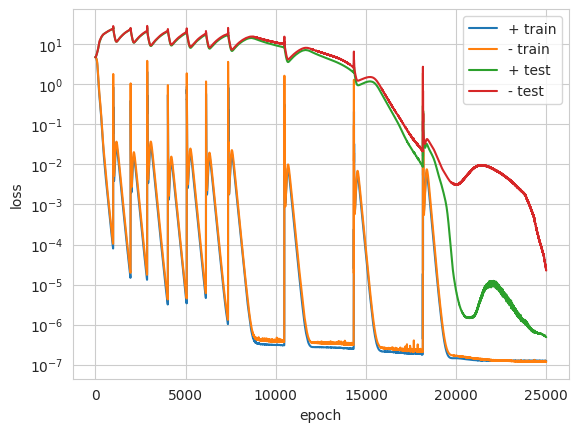

In [7]:
for operation in results['operations_losses']:
    plt.plot(operation['train_losses'])
for operation in results['operations_losses']:
    plt.plot(operation['test_losses'])
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['+ train', '- train', '+ test', '- test'])


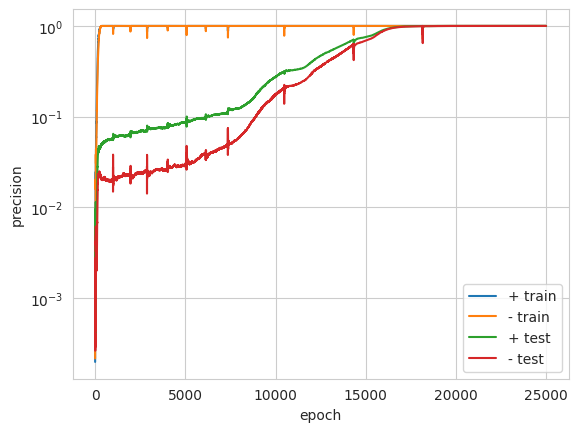

In [8]:
for operation in results['operations_losses']:
    plt.plot(operation['train_precisions'])
for operation in results['operations_losses']:
    plt.plot(operation['test_precisions'])
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['+ train', '- train', '+ test', '- test'])
plt.yscale('log')

In [9]:
from transformer_lens import HookedTransformer, HookedTransformerConfig, HookedEncoderDecoder

In [10]:
model = HookedTransformer(results['config'])
model.load_state_dict(results['model'])

<All keys matched successfully>

## Show model works

In [11]:
# (1 + 15) % 113
model(torch.tensor([1, 114, 15, 113]))[0,3].argmax().item()

16

In [12]:
# (1 - 15) % 113
model(torch.tensor([1, 115, 15, 113]))[0, 3].argmax().item()

99

## Run model on full dataset to look at activations/attention patterns

In [18]:
import einops
from modular_addition import ModularOperationsDataset
operations = (lambda x, y: x + y, lambda x, y: x - y)
dataset = ModularOperationsDataset(
    base=113,
    train_fraction=0.25,
    operations=operations,
)
full_dataset = einops.rearrange(dataset.data, "i j k -> (i k) j")
plus_dataset = dataset.data[:,:,0]
minus_dataset = dataset.data[:,:,1]
print(f"plus: {plus_dataset.shape}, minus: {minus_dataset.shape}, full: {full_dataset.shape}")

plus: torch.Size([12769, 4]), minus: torch.Size([12769, 4]), full: torch.Size([25538, 4])


In [19]:
output, cache = model.run_with_cache(full_dataset)

In [20]:
av_attention = cache["pattern", 0].mean(dim=0).detach().cpu()

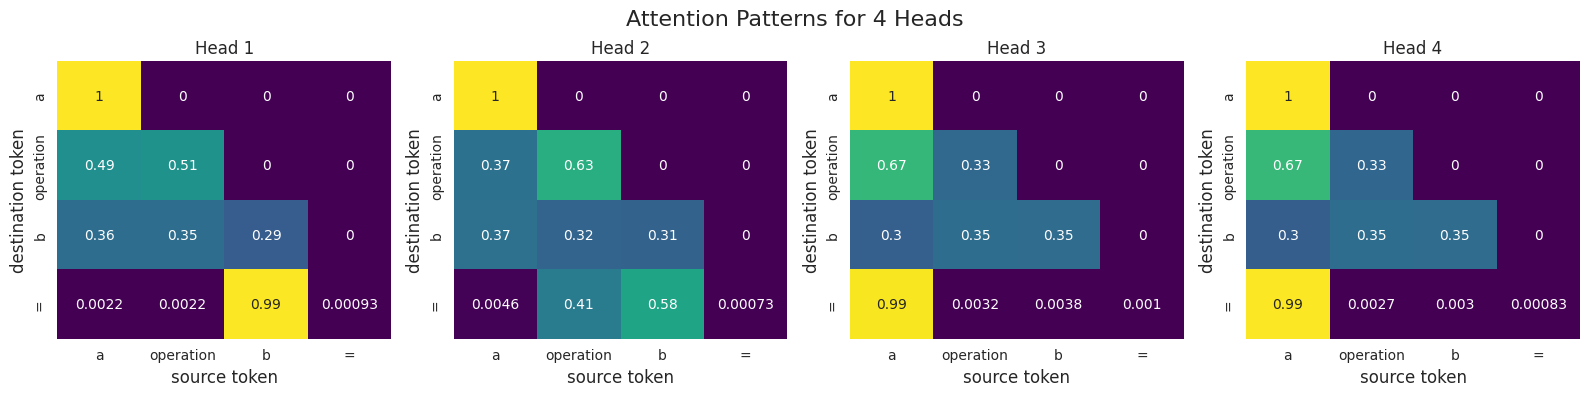

In [21]:
labels = ['a', 'operation', 'b', '=']
# Create a figure to hold the 4 attention head plots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        av_attention[i],
        annot=True,            # Annotate each cell with its value
        xticklabels=labels,    # Set x-axis labels
        yticklabels=labels,    # Set y-axis labels
        cmap="viridis",        # Use a color map
        cbar=False,            # Disable color bar to reduce clutter
        ax=ax,                  # Plot on the current axis
    )
    ax.set_title(f'Head {i + 1}', fontsize=12)
    ax.set_ylabel('destination token', fontsize=12)
    ax.set_xlabel('source token', fontsize=12)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

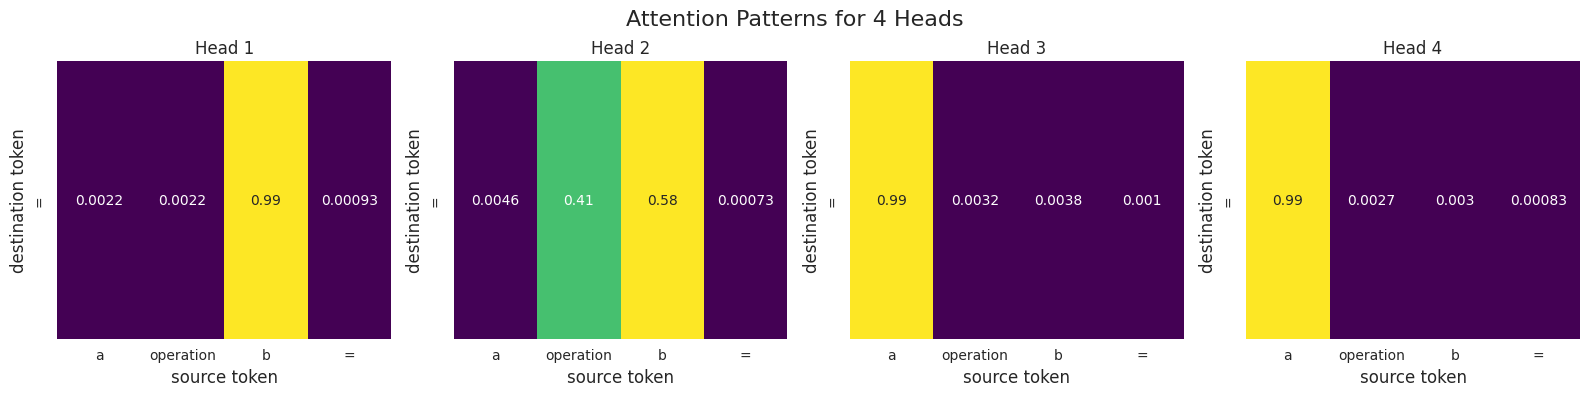

In [22]:
# plot just attn where = is the destination (all we care about)
labels = ['a', 'operation', 'b', '=']
# Create a figure to hold the 4 attention head plots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        av_attention[i, -1:],
        annot=True,            # Annotate each cell with its value
        xticklabels=labels,    # Set x-axis labels
        yticklabels=["="],    # Set y-axis labels
        cmap="viridis",        # Use a color map
        cbar=False,            # Disable color bar to reduce clutter
        ax=ax                  # Plot on the current axis
    )
    ax.set_title(f'Head {i + 1}', fontsize=12)
    ax.set_ylabel('destination token', fontsize=12)
    ax.set_xlabel('source token', fontsize=12)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

### Attention patterns for +

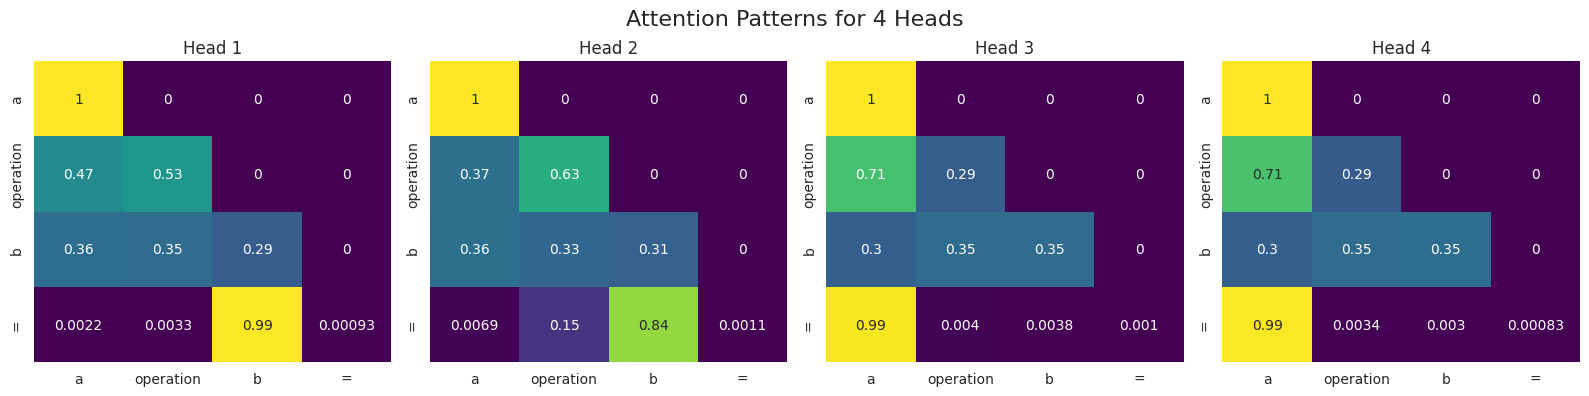

In [23]:
output_plus, cache_plus = model.run_with_cache(plus_dataset)
av_attention = cache_plus["pattern", 0].mean(dim=0).detach().cpu()
labels = ['a', 'operation', 'b', '=']
# Create a figure to hold the 4 attention head plots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        av_attention[i],
        annot=True,  # Annotate each cell with its value
        xticklabels=labels,  # Set x-axis labels
        yticklabels=labels,  # Set y-axis labels
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'Head {i + 1}', fontsize=12)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

### Attention patterns for -

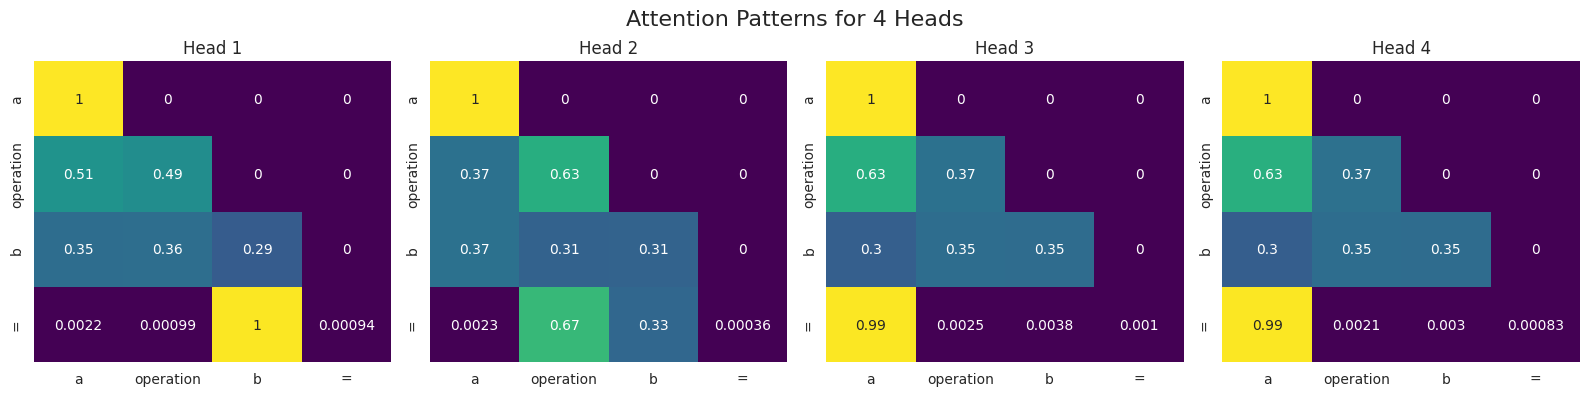

In [24]:
output_minus, cache_minus = model.run_with_cache(minus_dataset)
av_attention = cache_minus["pattern", 0].mean(dim=0).detach().cpu()
labels = ['a', 'operation', 'b', '=']
# Create a figure to hold the 4 attention head plots
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Attention Patterns for 4 Heads", fontsize=16)

# Loop through each head and plot its attention pattern
for i, ax in enumerate(axes):
    sns.heatmap(
        av_attention[i],
        annot=True,  # Annotate each cell with its value
        xticklabels=labels,  # Set x-axis labels
        yticklabels=labels,  # Set y-axis labels
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'Head {i + 1}', fontsize=12)

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

Next we plot the attention patterns for all combinations of a and b. Here we expect this to be very similar to what was found in the original paper with some potential interesting stuff on the openeration as the source attention.

/tmp/ipykernel_853495/1874702432.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_results = torch.load('output.pt')


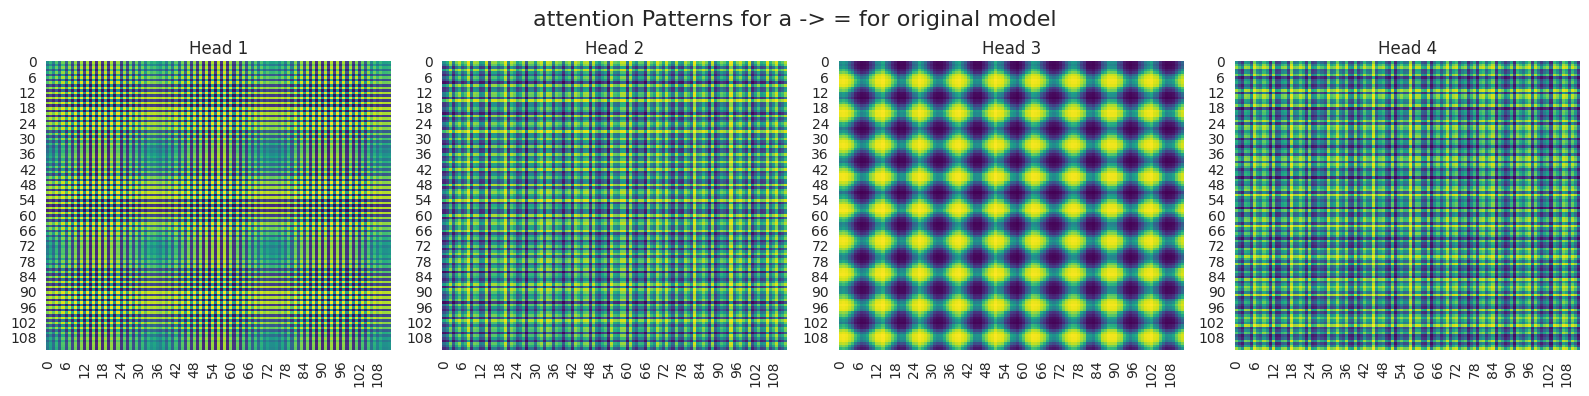

In [48]:
#Original model form paper
import einops
original_results = torch.load('output.pt')
original_model = HookedTransformer(original_results['config'])
original_model.load_state_dict(original_results['model'])
a_s = einops.repeat(torch.arange(113), "i -> (i j)", j=113)
b_s = einops.repeat(torch.arange(113), "j -> (i j)", i=113)
equals = einops.repeat(
    torch.tensor(113), " -> (i j)", i=113, j=113
)
original_dataset_correctly_ordered = torch.stack([a_s, b_s, equals], dim=1)
original_output, original_cache = original_model.run_with_cache(original_dataset_correctly_ordered)
a_to_equals_attn_patterns = original_cache["pattern", 0][:,:,-1,0].detach().cpu()
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("attention Patterns for a -> = for original model", fontsize=16)

# Loop through each head and plot its attention pattern

for i, ax in enumerate(axes):
    sns.heatmap(
        a_to_equals_attn_patterns[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'Head {i + 1}', fontsize=12)
# Loop through each head and plot its attention pattern

# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

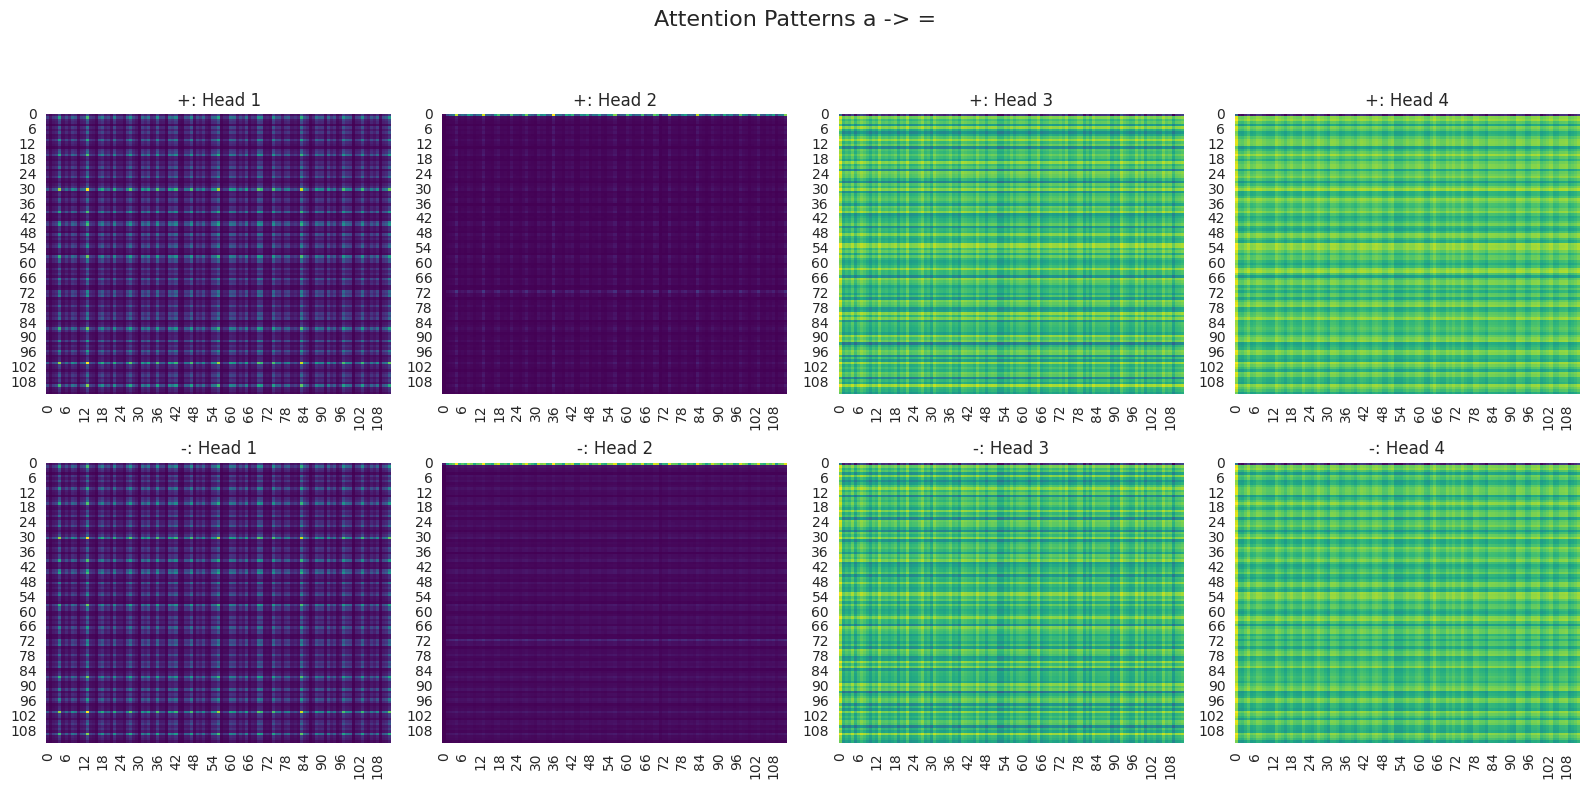

In [41]:
a_to_equals_attn_patterns_plus = cache_plus["pattern", 0][:,:,-1,0].detach().cpu()
a_to_equals_attn_patterns_minus = cache_minus["pattern", 0][:,:,-1,0].detach().cpu()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Attention Patterns a -> =", fontsize=16)

# Loop through each head and plot its attention pattern

for i, ax in enumerate(axes[0]):
    sns.heatmap(
        a_to_equals_attn_patterns_plus[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'+: Head {i + 1}', fontsize=12)

for i, ax in enumerate(axes[1]):

    sns.heatmap(
        a_to_equals_attn_patterns_minus[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'-: Head {i + 1}', fontsize=12)
# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

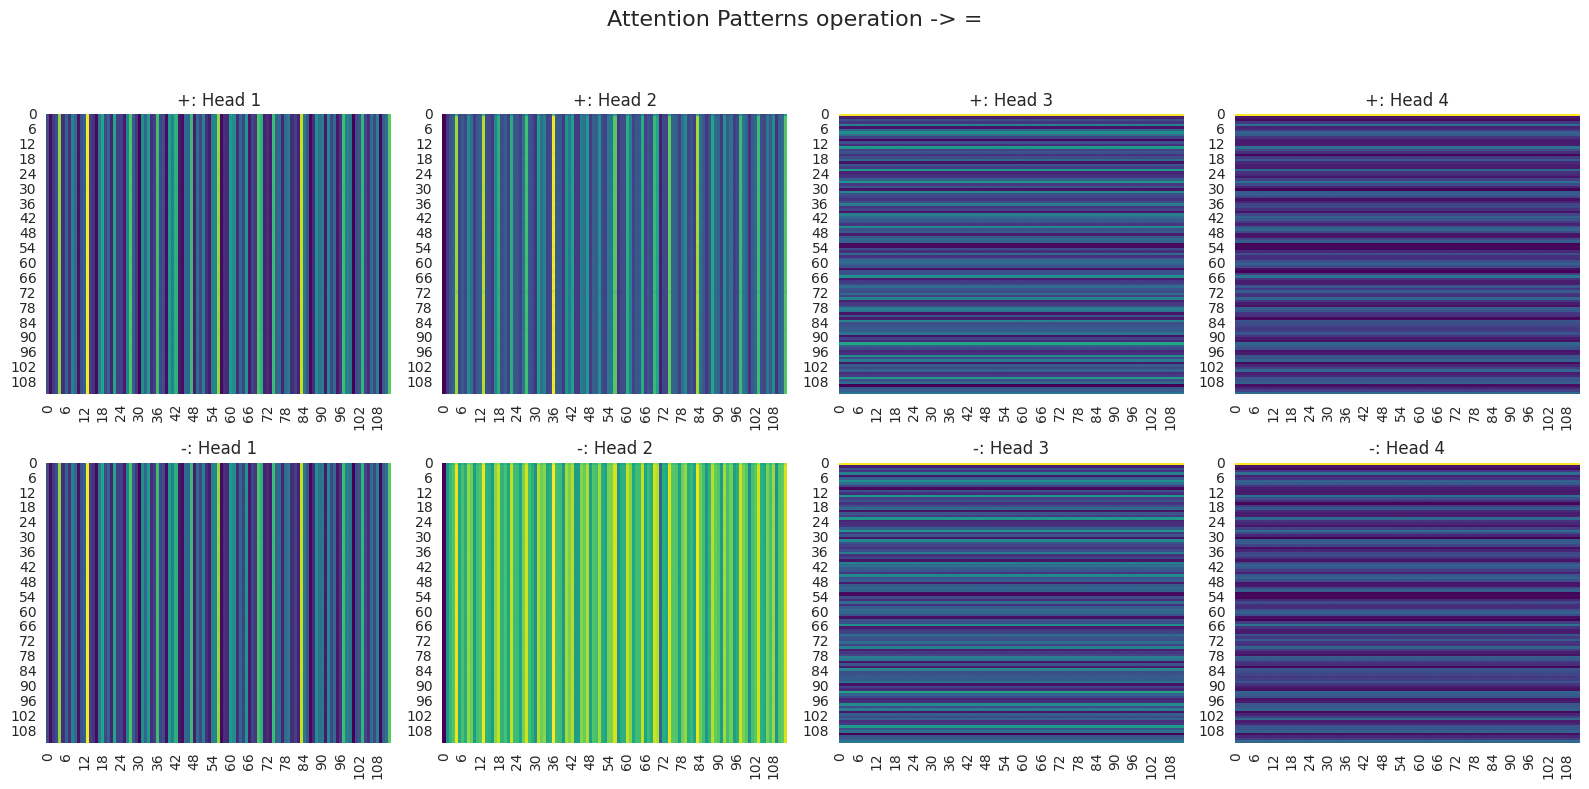

In [42]:
operation_to_equals_attn_patterns_plus = cache_plus["pattern", 0][:,:,-1,1].detach().cpu()
operation_to_equals_attn_patterns_minus = cache_minus["pattern", 0][:,:,-1,1].detach().cpu()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Attention Patterns operation -> =", fontsize=16)

# Loop through each head and plot its attention pattern

for i, ax in enumerate(axes[0]):
    sns.heatmap(
        operation_to_equals_attn_patterns_plus[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'+: Head {i + 1}', fontsize=12)

for i, ax in enumerate(axes[1]):

    sns.heatmap(
        operation_to_equals_attn_patterns_minus[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'-: Head {i + 1}', fontsize=12)
# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

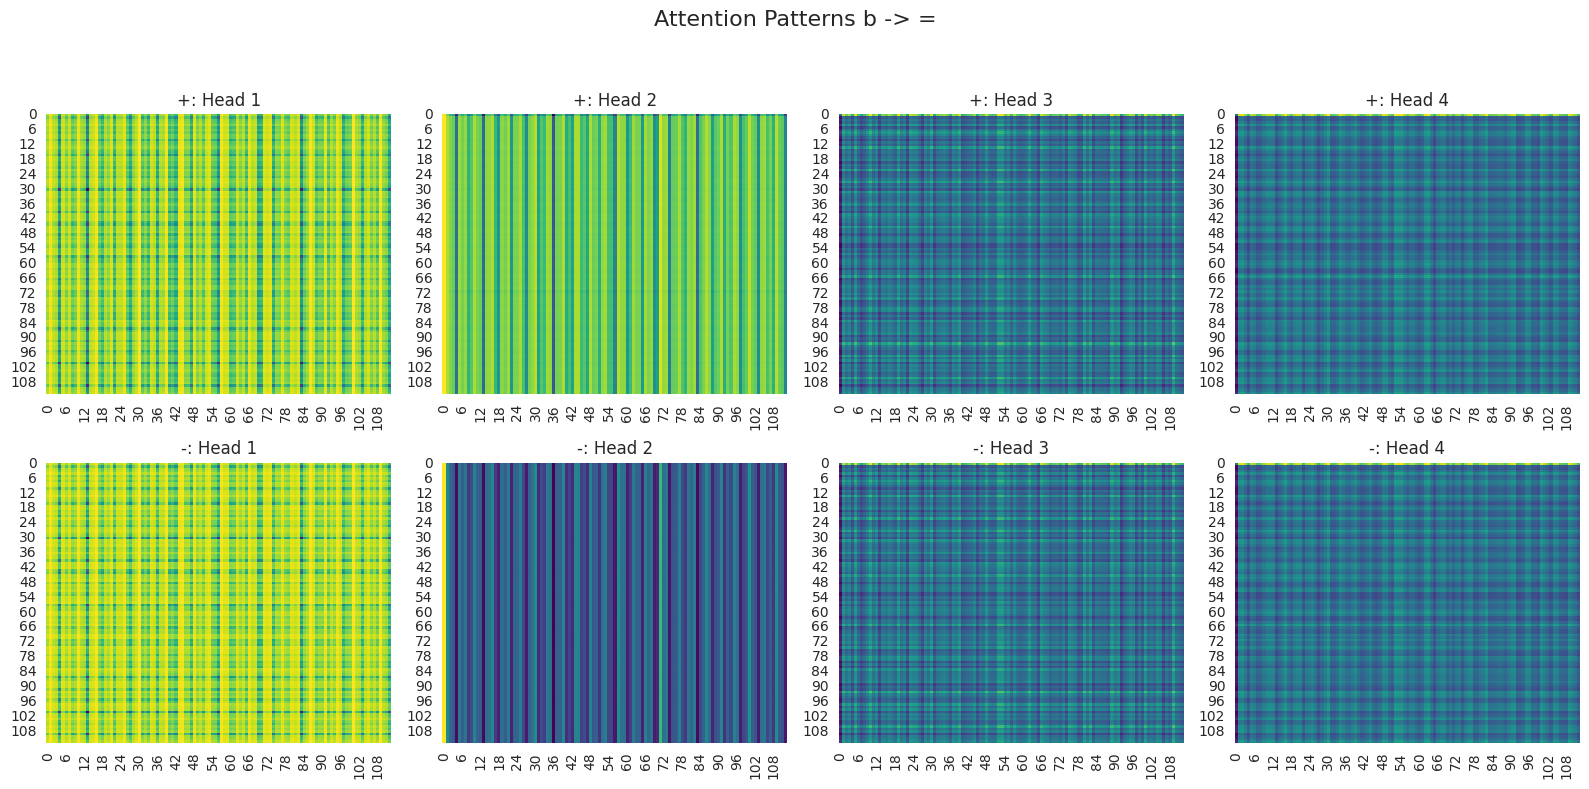

In [43]:
b_to_equals_attn_patterns_plus = cache_plus["pattern", 0][:,:,-1,2].detach().cpu()
b_to_equals_attn_patterns_minus = cache_minus["pattern", 0][:,:,-1,2].detach().cpu()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Attention Patterns b -> =", fontsize=16)

# Loop through each head and plot its attention pattern

for i, ax in enumerate(axes[0]):
    sns.heatmap(
        b_to_equals_attn_patterns_plus[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'+: Head {i + 1}', fontsize=12)

for i, ax in enumerate(axes[1]):

    sns.heatmap(
        b_to_equals_attn_patterns_minus[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'-: Head {i + 1}', fontsize=12)
# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

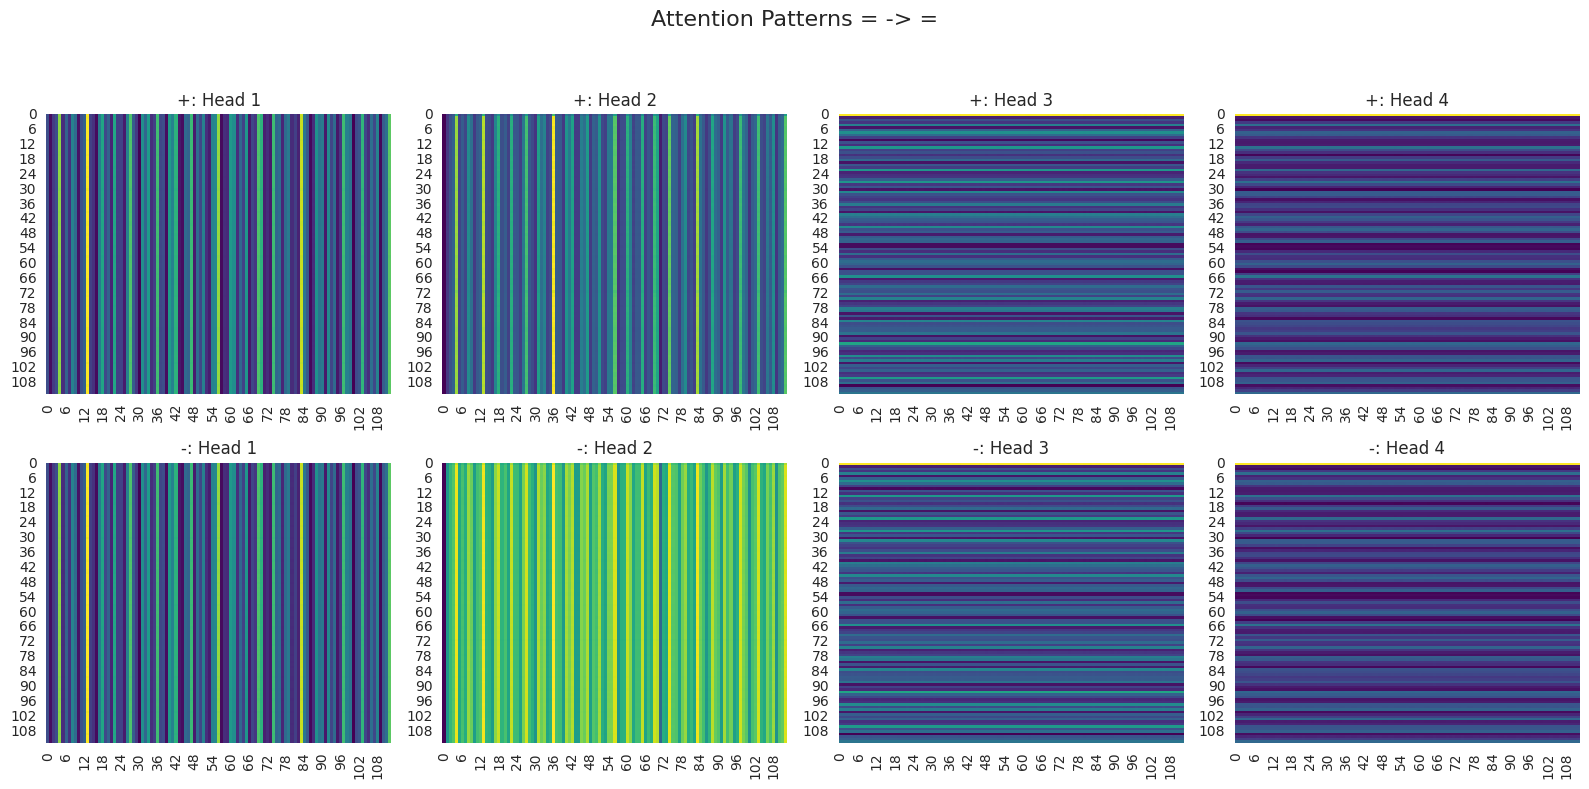

In [44]:
equals_to_equals_attn_patterns_plus = cache_plus["pattern", 0][:,:,-1,3].detach().cpu()
equals_to_equals_attn_patterns_minus = cache_minus["pattern", 0][:,:,-1,3].detach().cpu()
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Attention Patterns = -> =", fontsize=16)

# Loop through each head and plot its attention pattern

for i, ax in enumerate(axes[0]):
    sns.heatmap(
        equals_to_equals_attn_patterns_plus[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'+: Head {i + 1}', fontsize=12)

for i, ax in enumerate(axes[1]):

    sns.heatmap(
        equals_to_equals_attn_patterns_minus[:, i].reshape(113, 113),
        cmap="viridis",  # Use a color map
        cbar=False,  # Disable color bar to reduce clutter
        ax=ax  # Plot on the current axis
    )
    ax.set_title(f'-: Head {i + 1}', fontsize=12)
# Show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust to make space for the title
plt.show()

Definite periodicity but some interesting stuff happening. Maybe the model is learning a similar alg to the original but with more frequency components to accurately calculate both operations

# Staged Training

/tmp/ipykernel_2317215/1734121248.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load('output_plus_and_minus_staged.pt')


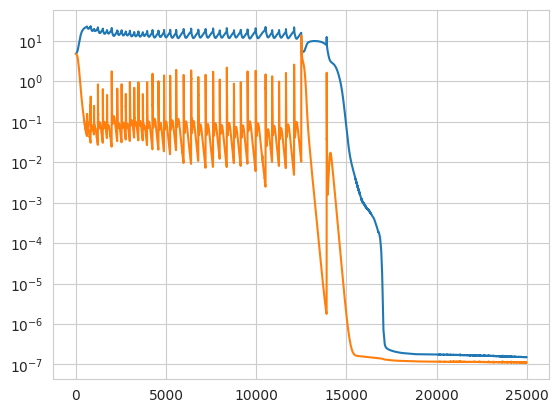

In [40]:
results = torch.load('output_plus_and_minus_staged.pt')
plt.plot(results['test_losses'])
plt.plot(results['train_losses'])
plt.yscale('log')



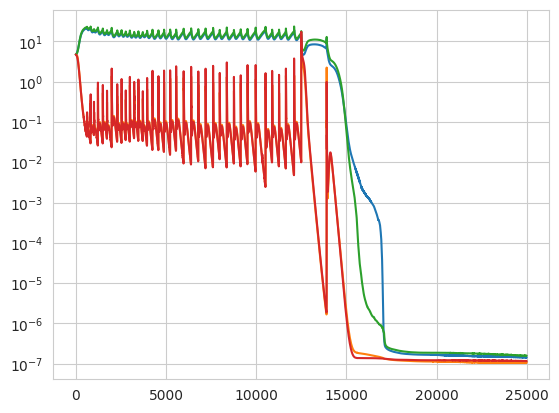

In [41]:
for operation in results['operations_losses']:
    plt.plot(operation['test_losses'])
    plt.plot(operation['train_losses'])
plt.yscale('log')